In [40]:
import pennylane as qml
import numpy as np
import torch
from torch import optim
from pennylane_ionq import SimulatorDevice

In [41]:
# functeion which conputes set of board, empty_rows, nonempty_rows
def status(horses,size):
    total_horses = horses 
    board = np.zeros((size,size))   
    row_list = [i for i in range(size)]

    nonempty_rows = [h[0] for h in total_horses]
    empty_rows = [x for x in row_list if x not in nonempty_rows]
    nonempty_rows.sort()

    for h in total_horses:
        board[h[0]][h[1]] = 1

    return board, empty_rows

In [42]:
# draw board
def draw(board):
    boxes = ['□', '◆']
    for row_board in board.tolist():
      for b in row_board:
        print(boxes[int(b)], end ='')
      print()

In [43]:
size = 4
num_qubits = size ** 2


dev = qml.device('default.qubit', wires=num_qubits)

@qml.qnode(dev)
def state_vec(weights, board,empty_rows):
    
    board = board.astype(int).reshape(1,-1).reshape([size**2,])
    qml.BasisStatePreparation(board, wires= range(num_qubits) )    

    for w in weights:
        th_count = 0
        n = size    
        for e in empty_rows:
            pivot = n * e 
            for j in range(n):
                qml.RX(w[th_count], wires = [pivot + j])
                th_count += 1

    return qml.probs()

# convert (size**2,1) tensor -> nomalized (size,size) tensor
def nomalization(result):
    return (-torch.FloatTensor(result).reshape([size,size])+1)*.5

In [44]:
@qml.qnode(dev, interface='torch')
def circuit(weights, board, empty_rows):


    board = board.astype(int).reshape(1,-1).reshape([size**2,])
    qml.BasisStatePreparation(board, wires= range(num_qubits) )    

    for w in weights:
        th_count = 0
        n = size    
        for e in empty_rows:
            pivot = n * e 
            for j in range(n):
                qml.RX(w[th_count], wires = [pivot + j])
                th_count += 1



    result = [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]
    return result

## Cost function (for 4X4 Board)

In [45]:
def cost_fn(result):
    
    ham = 0

    b = torch.stack(result, dim=0)
    result = b.reshape(4,4)
    
    # ham += torch.sum(b)

    for i in empty_rows:
        ham += torch.abs((torch.sum(result[i])-size+2)*(torch.sum(result[i])-size+2))
    for i in range(size):
        ham += torch.abs((torch.sum(result.T[i])-size+2)*(torch.sum(result.T[i])-size+2))


    for i in range(2*size-3): # 대각선 개수 2*size -1 -2(대각선 요소 1개인 것)
        diag1 = torch.diagonal(result,i-2)
        diag2 = torch.diagonal(torch.flip(result,[-1]),i-2)
        ham += torch.abs((torch.sum(diag1)-len(diag1))*(torch.sum(diag1)-len(diag1)+2))
        ham += torch.abs((torch.sum(diag2)-len(diag2))*(torch.sum(diag2)-len(diag2)+2))
    return ham


## Optimization

In [63]:
# set parameter
horses = [[0,2]]
board, empty_rows = status(horses,size)

num_layers = 2
N_iter = 50

weights = torch.tensor(torch.rand(num_layers , size*len(empty_rows)), requires_grad = True)

C:\Users\wlsgu\AppData\Local\Temp\ipykernel_4212\1072622285.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(torch.rand(num_layers , size*len(empty_rows)), requires_grad = True)


In [64]:
# Output the status of weights, cost, and board before implementation
exp_val = circuit(weights,board,empty_rows)
exp_board = nomalization(exp_val)
cost = cost_fn(exp_val)
print('cost is : ', float(cost))
print('board is ', np.array(exp_board))
print('weight is ',weights)

cost is :  14.711375022636387
board is  [[4.4703484e-07 4.4703484e-07 1.0000000e+00 0.0000000e+00]
 [3.6330143e-01 2.5308150e-01 2.1290320e-01 2.2217619e-01]
 [3.5399500e-01 8.6402476e-02 1.2751007e-01 2.0044172e-01]
 [5.3403294e-01 2.7609736e-01 3.1639457e-02 6.5975100e-02]]
weight is  tensor([[0.4405, 0.6905, 0.5047, 0.0768, 0.9372, 0.3664, 0.4088, 0.2951, 0.6397,
         0.5650, 0.1720, 0.1571],
        [0.8534, 0.3638, 0.4545, 0.9049, 0.3373, 0.2303, 0.3215, 0.6333, 0.9992,
         0.5415, 0.1856, 0.3625]], requires_grad=True)


### Draw Circuit

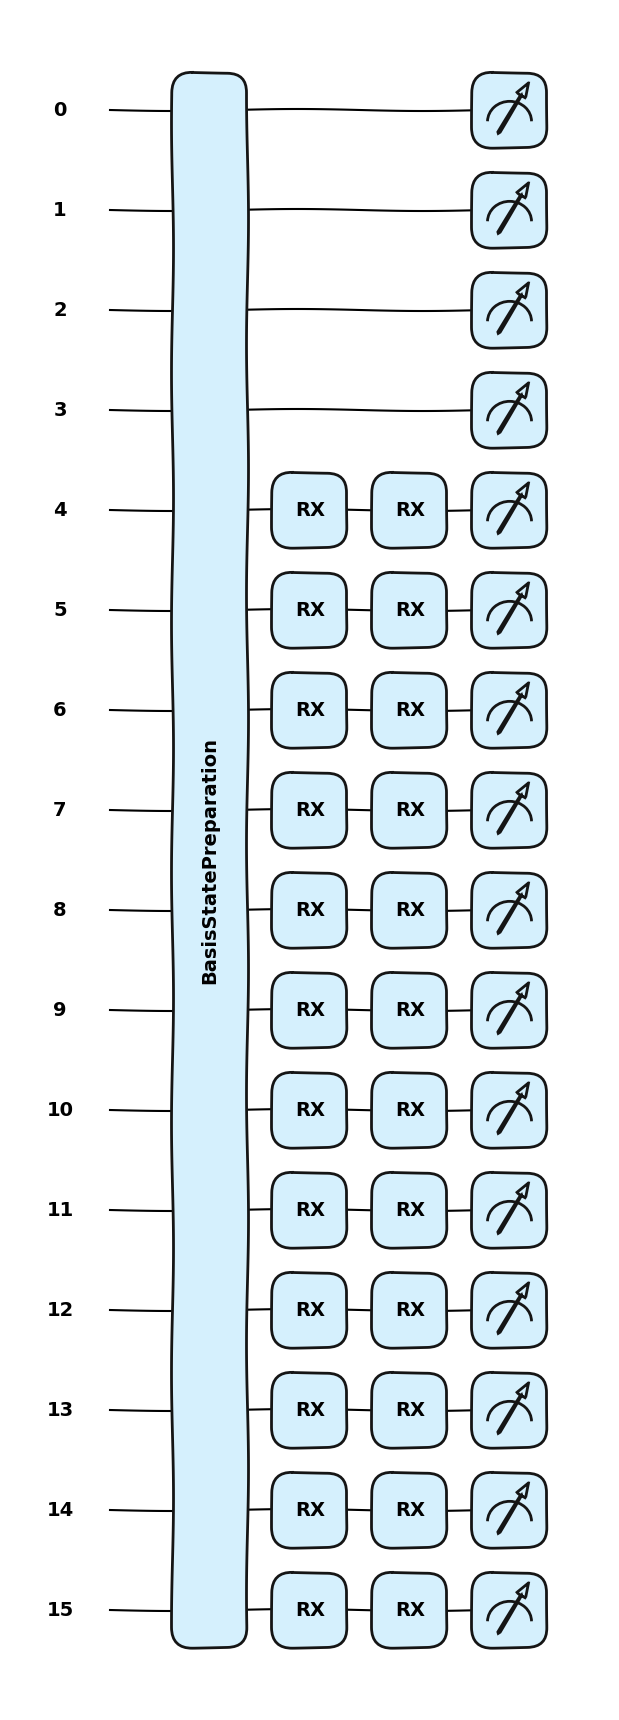

In [54]:
fig, ax = qml.draw_mpl(circuit,style= 'pennylane_sketch')(weights, board, empty_rows)

### Start optimazation

In [65]:
# start optimizing weights
optimizer = optim.Adam([weights],lr=0.7)

loss = []
for it in range(N_iter):
    cost = cost_fn(circuit(weights,board,empty_rows))
    loss.append(float(cost))
    optimizer.zero_grad() 
    cost.backward() 
    optimizer.step() 
    print('iteration number : ', it,' cost is ', cost)

iteration number :  0  cost is  tensor(14.7114, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  1  cost is  tensor(29.3165, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  2  cost is  tensor(15.7536, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  3  cost is  tensor(12.9833, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  4  cost is  tensor(17.5220, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  5  cost is  tensor(12.7427, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  6  cost is  tensor(10.2701, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  7  cost is  tensor(9.3995, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  8  cost is  tensor(12.8776, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  9  cost is  tensor(8.1872, dtype=torch.float64, grad_fn=<AddBackward0>)
iteration number :  10  cost is  tensor(6.6275, dtype=torch.float64, gra

## Result

In [66]:
# Output cost and board status after optimization is complete
state_f = state_vec(weights,board,empty_rows)
exp_val = circuit(weights,board,empty_rows)
exp_board = nomalization(exp_val)
cost = cost_fn(exp_val)

print('cost is : ', float(cost))
print('board is ', np.array(exp_board))
print('weight is ',weights)

cost is :  0.27171009404783736
board is  [[5.0663948e-07 5.0663948e-07 9.9999982e-01 2.0861626e-07]
 [9.9715555e-01 1.4394522e-05 2.7348995e-03 1.8959045e-03]
 [6.3192844e-04 6.2265992e-04 2.1320581e-04 9.9138123e-01]
 [1.1050999e-03 9.8733747e-01 5.4856241e-03 2.3016661e-02]]
weight is  tensor([[-1.8306,  0.1596,  0.0774, -0.4576,  0.3251,  0.0431,  0.0582, -1.6469,
         -0.1465, -1.6718,  0.0673, -3.0920],
        [-1.4177, -0.1672,  0.0272,  0.3705, -0.2748, -0.0930, -0.0290, -1.3088,
          0.2130, -1.6954,  0.0809, -2.8866]], requires_grad=True)


In [67]:
result_state = torch.argmax(state_f) # The state with the highest probability 
print(format(result_state,'016b'),'\nprobablity is ', float(max(state_f))*100,'%')
draw(np.array([int(i) for i in format(result_state,'016b')]).reshape([4,4]))

0010100000010100 
probablity is  94.15225982666016 %
□□◆□
◆□□□
□□□◆
□◆□□


### LOSS

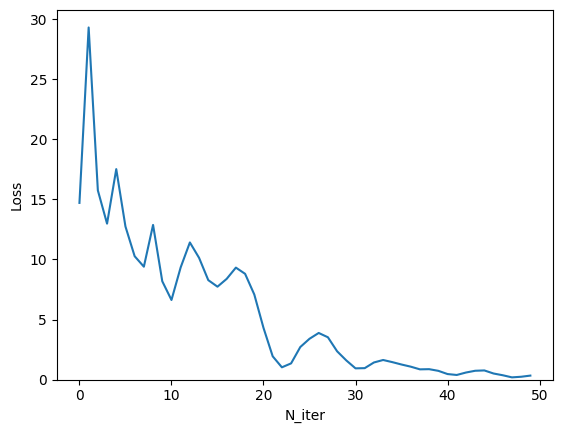

In [68]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('N_iter')
plt.ylabel('Loss')
plt.ylim(0)
plt.savefig('loss')
plt.show()